(1600, 1237, 3)


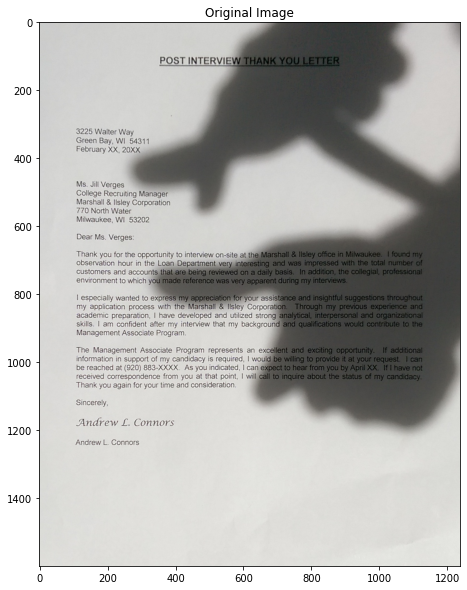

In [45]:
# Implementation of Shah et al. (2018)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color,filters,transform,io
from scipy import ndimage as ndi
from helper_functions import *
from tqdm import tqdm


base_img_rpath = '../dataset/document/'
base_img_wpath = '../output/document/'

#choices = 'document.png', 'color_mosaic.jpg', 'textbook.jpg', 'manuscript.jpg'
filename = 'document.png'
doc = Image.open(base_img_rpath + filename)
doc_orig = np.array(doc)

# rescale for faster computation
#doc_orig = transform.rescale(doc_orig, scale= 0.25, channel_axis=2) #comment if req
#doc_orig = np.round(doc_orig*255.0)
#doc_orig = doc_orig.astype(np.uint8)

#io.imsave(base_img_wpath+"scaled_doc.png", doc_orig)

plt.figure(figsize = (8,10))
plt.imshow(doc_orig)
plt.title('Original Image')
plt.show()

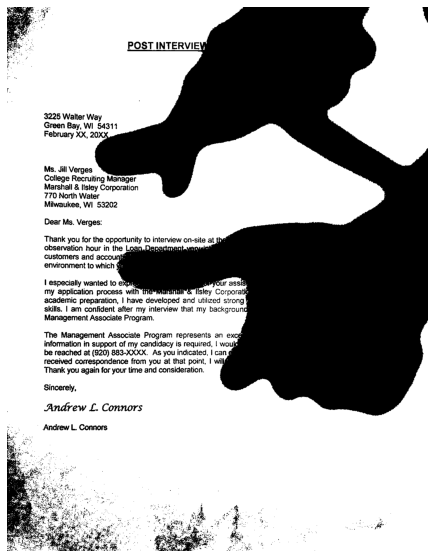

In [46]:
# Binarization (using Bradley et. al)

doc_orig_gray = color.rgb2gray(doc_orig)
threshold_mask = filters.threshold_local(doc_orig_gray, block_size=1201)#501
#threshold_mask = threshold_mask.astype(np.uint8)
binary_image = doc_orig_gray > threshold_mask
plt.figure(figsize = (8,10))
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
#plt.savefig(base_img_wpath + filename[:-4] + '_iter' + '_threshold'+ '.jpg')
plt.show()

100%|██████████| 1600/1600 [00:05<00:00, 298.91it/s]


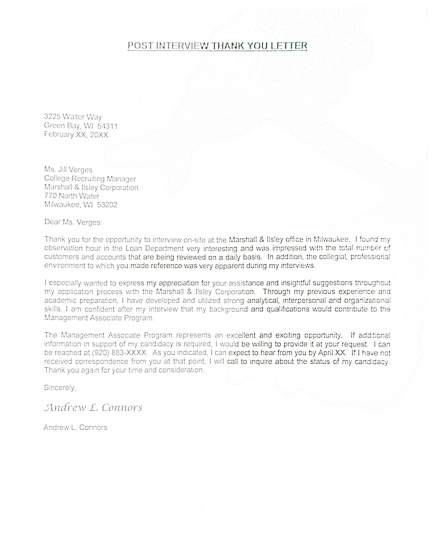

In [48]:
# Shading Map Estimation (non-adaptive approach)
## binary_image : 1 = background, 0 = foreground
## Background pixels remain the same
## Foreground pixels are replaced with the average of the surrounding pixels


window_size = 15 # odd-only
d = window_size//2

shadow_map = np.zeros(doc_orig.shape)
m = doc_orig.shape[0]
n = doc_orig.shape[1]
n_iter = 2

iter_binary_image = binary_image
iter_reflectance = doc_orig

for iter in range(n_iter):

    for c_ch in range(3):
        for row in tqdm(range(m)):
            for col in range(n):
                if iter_binary_image[row, col] == 1:
                    shadow_map[row, col, c_ch] = iter_reflectance[row, col, c_ch]
                else:
                    window = iter_reflectance[max(row-d,0):min(row+d+1,m-1), max(col-d,0):min(col+d+1,n-1), c_ch]
                    shadow_map[row][col][c_ch] = np.mean(window)

    shadow_map = shadow_map.astype(np.uint8)

    iter_reflectance = iter_reflectance / shadow_map
    iter_reflectance = iter_reflectance.clip(0,1)
    iter_reflectance = np.round(iter_reflectance*255.0)
    iter_reflectance = iter_reflectance.astype(np.uint8)

    
    iter_reflectance_gray = color.rgb2gray(iter_reflectance)
    threshold_mask = filters.threshold_local(iter_reflectance_gray, block_size=501)
    iter_binary_image = iter_reflectance_gray > threshold_mask
    
    
 
plt.figure(figsize = (8,10))
plt.imshow(iter_reflectance)
plt.axis('off')
#plt.savefig(base_img_wpath + filename[:-4] + '_iter_' + str(n_iter) + '_win_' + str(d) + '.jpg')
plt.show()